In [2]:
import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Nice display defaults
pd.set_option('display.max_colwidth', 200)
plt.rcParams['figure.figsize'] = (9,4)
plt.rcParams['axes.grid'] = True

DATA_PATH = os.path.join('..', 'data', 'products.csv')
assert os.path.exists(DATA_PATH), f"CSV not found at {DATA_PATH}"
DATA_PATH


'..\\data\\products.csv'

In [3]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head(3)


Shape: (312, 12)


,title,brand,description,price,categories,images,manufacturer,package_dimensions,country_of_origin,material,color,uniq_id
0,"GOYMFK 1pc Free Standing Shoe Rack, Multi-layer Metal Shoe Cap Rack With 8 Double Hooks For Living Room, Bathroom, Hallway",GOYMFK,"multiple shoes, coats, hats, and other items Easy to assemble: Includes all necessary hardware and instructions for easy assembly Versatile: Perfect for use in living rooms, bathrooms, hallways, a...",$24.99,"['Home & Kitchen', 'Storage & Organization', 'Clothing & Closet Storage', 'Shoe Organizers', 'Free Standing Shoe Racks']","['https://m.media-amazon.com/images/I/416WaLx10jL._SS522_.jpg ', ' https://m.media-amazon.com/images/I/41kuxipTsuL._SS522_.jpg ', ' https://m.media-amazon.com/images/I/51T9x4yZd3L._SS522_.jpg ', '...",GOYMFK,"2.36""D x 7.87""W x 21.6""H",China,Metal,White,02593e81-5c09-5069-8516-b0b29f439ded
1,"subrtex Leather ding Room, Dining Chairs Set of 2, Black",subrtex,subrtex Dining chairs Set of 2,NaN,"['Home & Kitchen', 'Furniture', 'Dining Room Furniture', 'Chairs']","['https://m.media-amazon.com/images/I/31SejUEWY7L._SS522_.jpg ', ' https://m.media-amazon.com/images/I/41mr+A9JmbL._SS522_.jpg ', ' https://m.media-amazon.com/images/I/41JjrWgA0XL._SS522_.jpg ', '...",Subrtex Houseware INC,"18.5""D x 16""W x 35""H",NaN,Sponge,Black,5938d217-b8c5-5d3e-b1cf-e28e340f292e
2,"Plant Repotting Mat MUYETOL Waterproof Transplanting Mat Indoor 26.8"" x 26.8"" Portable Square Foldable Easy to Clean Gardening Work Mat Soil Changing Mat Succulent Plant Transplanting Mat Garden G...",MUYETOL,NaN,$5.98,"['Patio, Lawn & Garden', 'Outdoor Décor', 'Doormats']","['https://m.media-amazon.com/images/I/41RgefVq70L._SS522_.jpg ', ' https://m.media-amazon.com/images/I/414SPEuzxlL._SS522_.jpg ', ' https://m.media-amazon.com/images/I/51gknsPKCHL._SS522_.jpg ', '...",MUYETOL,"26.8""L x 26.8""W",NaN,Polyethylene,Green,b2ede786-3f51-5a45-9a5b-bcf856958cd8


In [4]:
df.info()
print("\nTop nulls:")
df.isna().sum().sort_values(ascending=False).head(12)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               312 non-null    object
 1   brand               312 non-null    object
 2   description         159 non-null    object
 3   price               215 non-null    object
 4   categories          312 non-null    object
 5   images              312 non-null    object
 6   manufacturer        205 non-null    object
 7   package_dimensions  306 non-null    object
 8   country_of_origin   125 non-null    object
 9   material            218 non-null    object
 10  color               265 non-null    object
 11  uniq_id             312 non-null    object
dtypes: object(12)
memory usage: 29.4+ KB

Top nulls:


country_of_origin     187
description           153
manufacturer          107
price                  97
material               94
color                  47
package_dimensions      6
brand                   0
title                   0
images                  0
categories              0
uniq_id                 0
dtype: int64

In [6]:
# Trim whitespace in column names
df.columns = [c.strip() for c in df.columns]

# Helpful lower->actual name lookup
lower_to_actual = {c.lower(): c for c in df.columns}

expected = [
    'uniq_id','title','brand','description','price','categories','images',
    'manufacturer','package dimensions','country_of_origin','material','color'
]

missing = [col for col in expected if col not in lower_to_actual]
print("Missing (if any):", missing)

# If you have close variants, fix them here (add/adjust as needed):
remap_candidates = {
    'country of origin': 'country_of_origin',
    'package_dimensions': 'package dimensions',
    'image': 'images',
}
for src, dst in remap_candidates.items():
    if src in df.columns and dst not in df.columns:
        df[dst] = df[src]


Missing (if any): ['package dimensions']


In [7]:
def parse_price(x):
    """Convert price string like '₹2,499' or '2499' to float."""
    s = str(x)
    s = re.sub(r'[^\d.\-]', '', s)  # keep digits, dot, minus
    try:
        return float(s)
    except:
        return np.nan

def first_cat(s):
    """Take first category if comma-separated."""
    if pd.isna(s): return ''
    parts = [p.strip() for p in str(s).split(',') if p.strip()]
    return parts[0] if parts else ''

def first_img(s):
    """Take first image URL if comma-separated."""
    if pd.isna(s): return ''
    return str(s).split(',')[0].strip()

df['price_num'] = df.get('price', np.nan).apply(parse_price)
df['category_main'] = df.get('categories', '').apply(first_cat)
df['image_0'] = df.get('images', '').apply(first_img)

df[['uniq_id','title','price','price_num','category_main','image_0']].head(5)


,uniq_id,title,price,price_num,category_main,image_0
0,02593e81-5c09-5069-8516-b0b29f439ded,"GOYMFK 1pc Free Standing Shoe Rack, Multi-layer Metal Shoe Cap Rack With 8 Double Hooks For Living Room, Bathroom, Hallway",$24.99,24.99,['Home & Kitchen',['https://m.media-amazon.com/images/I/416WaLx10jL._SS522_.jpg '
1,5938d217-b8c5-5d3e-b1cf-e28e340f292e,"subrtex Leather ding Room, Dining Chairs Set of 2, Black",NaN,NaN,['Home & Kitchen',['https://m.media-amazon.com/images/I/31SejUEWY7L._SS522_.jpg '
2,b2ede786-3f51-5a45-9a5b-bcf856958cd8,"Plant Repotting Mat MUYETOL Waterproof Transplanting Mat Indoor 26.8"" x 26.8"" Portable Square Foldable Easy to Clean Gardening Work Mat Soil Changing Mat Succulent Plant Transplanting Mat Garden G...",$5.98,5.98,['Patio,['https://m.media-amazon.com/images/I/41RgefVq70L._SS522_.jpg '
3,8fd9377b-cfa6-5f10-835c-6b8eca2816b5,"Pickleball Doormat, Welcome Doormat Absorbent Non-Slip Floor Mat Bathroom Mat 16x24",$13.99,13.99,['Patio,['https://m.media-amazon.com/images/I/61vz1IglerL._SS522_.jpg '
4,bdc9aa30-9439-50dc-8e89-213ea211d66a,"JOIN IRON Foldable TV Trays for Eating Set of 4 with Stand,Folding TV/Snack Tray Table Set,Folding TV Dinner Tables for Small Space,(Grey)",$89.99,89.99,['Home & Kitchen',['https://m.media-amazon.com/images/I/41p4d4VJnNL._SS522_.jpg '


In [8]:
# Category counts
cat_counts = df['category_main'].value_counts()
print("Top categories:")
cat_counts.head(15)


Top categories:


category_main
['Home & Kitchen'              254
['Patio                         23
['Tools & Home Improvement'     17
['Electronics'                   6
['Baby Products'                 6
['Beauty & Personal Care'        4
['Office Products'               2
Name: count, dtype: int64

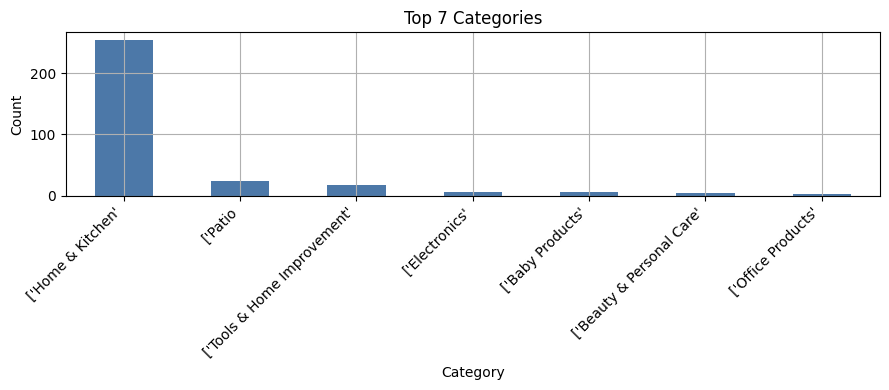

In [9]:
# Bar chart: top categories (up to 20)
top_k = 20
ax = cat_counts.head(top_k).plot(kind='bar', color='#4C78A8')
ax.set_title(f'Top {min(top_k, len(cat_counts))} Categories')
ax.set_xlabel('Category')
ax.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [10]:
# Price stats
price_stats = df['price_num'].dropna().describe()
price_stats


count    215.000000
mean      67.630651
std       57.962150
min        0.600000
25%       24.990000
50%       53.990000
75%       89.990000
max      349.000000
Name: price_num, dtype: float64

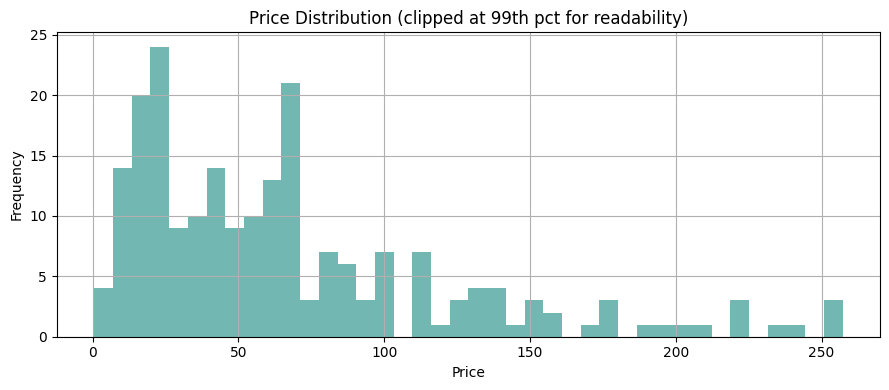

In [11]:
# Price histogram (clip extremes to make the distribution readable if needed)
vals = df['price_num'].dropna().values
if len(vals) > 0:
    hi = np.percentile(vals, 99)  # clip at 99th percentile for display
    plt.hist(np.clip(vals, None, hi), bins=40, color='#72B7B2')
    plt.title('Price Distribution (clipped at 99th pct for readability)')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
else:
    print("No numeric prices available.")


In [12]:
nulls = (
    df.isna().sum()
      .to_frame('nulls')
      .assign(pct=lambda t: (t['nulls']/len(df)).round(4))
      .sort_values('nulls', ascending=False)
)
nulls.head(12)


,nulls,pct
country_of_origin,187,0.5994
description,153,0.4904
manufacturer,107,0.3429
price,97,0.3109
price_num,97,0.3109
material,94,0.3013
color,47,0.1506
package_dimensions,6,0.0192
package dimensions,6,0.0192
images,0,0.0000


In [13]:
def coalesce(*vals):
    return ' '.join([str(v) for v in vals if pd.notna(v) and str(v).strip()])

df['doc'] = df.apply(lambda r: coalesce(
    r.get('title'), r.get('brand'), r.get('description'),
    r.get('material'), r.get('color')
), axis=1)

df[['uniq_id','doc']].head(5)


,uniq_id,doc
0,02593e81-5c09-5069-8516-b0b29f439ded,"GOYMFK 1pc Free Standing Shoe Rack, Multi-layer Metal Shoe Cap Rack With 8 Double Hooks For Living Room, Bathroom, Hallway GOYMFK multiple shoes, coats, hats, and other items Easy to assemble: Inc..."
1,5938d217-b8c5-5d3e-b1cf-e28e340f292e,"subrtex Leather ding Room, Dining Chairs Set of 2, Black subrtex subrtex Dining chairs Set of 2 Sponge Black"
2,b2ede786-3f51-5a45-9a5b-bcf856958cd8,"Plant Repotting Mat MUYETOL Waterproof Transplanting Mat Indoor 26.8"" x 26.8"" Portable Square Foldable Easy to Clean Gardening Work Mat Soil Changing Mat Succulent Plant Transplanting Mat Garden G..."
3,8fd9377b-cfa6-5f10-835c-6b8eca2816b5,"Pickleball Doormat, Welcome Doormat Absorbent Non-Slip Floor Mat Bathroom Mat 16x24 VEWETOL The decorative doormat features a subtle textured surface that absorbs moisture and helps remove dirt an..."
4,bdc9aa30-9439-50dc-8e89-213ea211d66a,"JOIN IRON Foldable TV Trays for Eating Set of 4 with Stand,Folding TV/Snack Tray Table Set,Folding TV Dinner Tables for Small Space,(Grey) JOIN IRON Store Set of Four Folding Trays With Matching S..."


In [14]:
clean_path = os.path.join('..','data','products_cleaned.csv')
df.to_csv(clean_path, index=False)
clean_path


'..\\data\\products_cleaned.csv'

In [15]:
analytics = {
    "category_counts": df['category_main'].value_counts().to_dict(),
    "price_stats": df['price_num'].dropna().describe().to_dict()
}

os.makedirs(os.path.join('..','data','derived'), exist_ok=True)
preview_path = os.path.join('..','data','derived','analytics_preview.json')
with open(preview_path, 'w', encoding='utf-8') as f:
    json.dump(analytics, f, indent=2)

preview_path, list(analytics.keys())


('..\\data\\derived\\analytics_preview.json',
 ['category_counts', 'price_stats'])

In [16]:
sample = (df[['uniq_id','title','brand','price','category_main','image_0']]
          .head(10)
          .fillna(''))
sample


,uniq_id,title,brand,price,category_main,image_0
0,02593e81-5c09-5069-8516-b0b29f439ded,"GOYMFK 1pc Free Standing Shoe Rack, Multi-layer Metal Shoe Cap Rack With 8 Double Hooks For Living Room, Bathroom, Hallway",GOYMFK,$24.99,['Home & Kitchen',['https://m.media-amazon.com/images/I/416WaLx10jL._SS522_.jpg '
1,5938d217-b8c5-5d3e-b1cf-e28e340f292e,"subrtex Leather ding Room, Dining Chairs Set of 2, Black",subrtex,,['Home & Kitchen',['https://m.media-amazon.com/images/I/31SejUEWY7L._SS522_.jpg '
2,b2ede786-3f51-5a45-9a5b-bcf856958cd8,"Plant Repotting Mat MUYETOL Waterproof Transplanting Mat Indoor 26.8"" x 26.8"" Portable Square Foldable Easy to Clean Gardening Work Mat Soil Changing Mat Succulent Plant Transplanting Mat Garden G...",MUYETOL,$5.98,['Patio,['https://m.media-amazon.com/images/I/41RgefVq70L._SS522_.jpg '
3,8fd9377b-cfa6-5f10-835c-6b8eca2816b5,"Pickleball Doormat, Welcome Doormat Absorbent Non-Slip Floor Mat Bathroom Mat 16x24",VEWETOL,$13.99,['Patio,['https://m.media-amazon.com/images/I/61vz1IglerL._SS522_.jpg '
4,bdc9aa30-9439-50dc-8e89-213ea211d66a,"JOIN IRON Foldable TV Trays for Eating Set of 4 with Stand,Folding TV/Snack Tray Table Set,Folding TV Dinner Tables for Small Space,(Grey)",JOIN IRON Store,$89.99,['Home & Kitchen',['https://m.media-amazon.com/images/I/41p4d4VJnNL._SS522_.jpg '
5,20da3703-26f1-53e5-aa0b-a8104527d1bb,"LOVMOR 30'' Bathroom Vanity Sink Base Cabine, Storage Cabinet with 3-Drawers on The Left, Suitable for Bathrooms, Kitchens, Laundry Rooms and Other Places.",LOVMOR,,['Home & Kitchen',['https://m.media-amazon.com/images/I/41zMuj2wvvL._SS522_.jpg '
6,aba4138e-6401-52ca-a099-02e30b638db4,"Folews Bathroom Organizer Over The Toilet Storage, 4-Tier Bathroom Shelves Over Toilet Shelf Above Toilet Storage Rack Freestanding Bathroom Space Saver Adjustable Shelves and Baskets, Black",Folews Store,$63.99,['Home & Kitchen',['https://m.media-amazon.com/images/I/41ixgM73DgL._SS522_.jpg '
7,02593e81-5c09-5069-8516-b0b29f439ded,"GOYMFK 1pc Free Standing Shoe Rack, Multi-layer Metal Shoe Cap Rack With 8 Double Hooks For Living Room, Bathroom, Hallway",GOYMFK,$24.99,['Home & Kitchen',['https://m.media-amazon.com/images/I/416WaLx10jL._SS522_.jpg '
8,5938d217-b8c5-5d3e-b1cf-e28e340f292e,"subrtex Leather ding Room, Dining Chairs Set of 2, Black",subrtex,,['Home & Kitchen',['https://m.media-amazon.com/images/I/31SejUEWY7L._SS522_.jpg '
9,b2ede786-3f51-5a45-9a5b-bcf856958cd8,"Plant Repotting Mat MUYETOL Waterproof Transplanting Mat Indoor 26.8"" x 26.8"" Portable Square Foldable Easy to Clean Gardening Work Mat Soil Changing Mat Succulent Plant Transplanting Mat Garden G...",MUYETOL,$5.98,['Patio,['https://m.media-amazon.com/images/I/41RgefVq70L._SS522_.jpg '
